# 기상 특성에 따른 안개 발생 진단

## 데이터 설명
- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 데이터 불러오기

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [100]:
# 데이터셋 경로 지정
# train_path = "C:/Users/aryij/Downloads/fog_python/fog_train.csv"
# test_path = "C:/Users/aryij/Downloads/fog_python/fog_test.csv"

train_path = "../fog_data/fog_train.csv"
test_path = "../fog_data/fog_test.csv"

In [101]:
# 데이터셋 불러오기
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)

In [4]:
train_df.head()

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4


In [5]:
test_df.head()

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
1,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
2,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
3,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
4,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
5,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN


In [6]:
train_df.shape, test_df.shape

((3156459, 15), (262800, 14))

## 데이터 확인

In [7]:
train_df.describe(include="all")

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
count,3156459,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3156459,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06
unique,3,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,I,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1054060,NaN,NaN,NaN,NaN,157823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.521931e+00,1.573276e+01,1.150007e+01,2.500016e+01,NaN,1.852152e+02,1.999417e+00,1.328812e+01,-4.298995e-01,6.667729e+01,-1.288869e+00,1.282955e+01,1.963548e+04,3.246275e+00
std,NaN,3.448969e+00,8.801320e+00,6.922149e+00,1.707819e+01,NaN,1.072184e+02,4.721616e+00,1.100537e+01,6.929268e+00,2.173623e+01,1.171355e+01,2.257327e+01,1.206407e+04,8.668957e+00
min,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.900000e+01,-9.900000e+01
25%,NaN,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,NaN,8.470000e+01,9.000000e-01,5.500000e+00,0.000000e+00,5.130000e+01,0.000000e+00,5.100000e+00,1.229700e+04,4.000000e+00
50%,NaN,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,NaN,2.094000e+02,1.800000e+00,1.430000e+01,0.000000e+00,6.870000e+01,0.000000e+00,1.570000e+01,2.000000e+04,4.000000e+00
75%,NaN,1.000000e+01,2.300000e+01,1.800000e+01,4.000000e+01,NaN,2.769000e+02,3.000000e+00,2.200000e+01,0.000000e+00,8.470000e+01,1.600000e-01,2.430000e+01,2.000000e+04,4.000000e+00


In [8]:
test_df.describe(include="all")

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
count,262800,262800.000000,262800.000000,262800.0000,262800.000000,262800,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,2694.0
unique,1,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,L,NaN,NaN,NaN,NaN,AI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,262800,NaN,NaN,NaN,NaN,52560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.526027,15.720548,11.5000,25.000000,NaN,196.658506,2.209763,13.762124,-1.659824,66.988850,0.057753,12.861969,-99.0
std,NaN,3.447858,8.796264,6.9222,17.078284,NaN,102.654641,3.479083,10.731883,12.973129,21.925011,2.097243,22.992859,0.0
min,NaN,1.000000,1.000000,0.0000,0.000000,NaN,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.0
25%,NaN,4.000000,8.000000,5.7500,10.000000,NaN,108.900000,1.000000,5.600000,0.000000,51.100000,0.000000,4.600000,-99.0
50%,NaN,7.000000,16.000000,11.5000,25.000000,NaN,220.400000,2.000000,15.100000,0.000000,69.300000,0.000000,15.900000,-99.0
75%,NaN,10.000000,23.000000,17.2500,40.000000,NaN,287.100000,3.100000,22.600000,0.000000,86.100000,0.170000,24.500000,-99.0


In [102]:
# train_df, test_df 컬럼들 앞에 있는 fog_train, fog_test. <- 제거
train_df.columns = train_df.columns.str.replace("fog_train.", "")
test_df.columns = test_df.columns.str.replace("fog_test.", "")

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3156459 entries, 1 to 3156459
Data columns (total 15 columns):
 #   Column    Dtype  
---  ------    -----  
 0   year      object 
 1   month     int64  
 2   day       int64  
 3   time      int64  
 4   minute    int64  
 5   stn_id    object 
 6   ws10_deg  float64
 7   ws10_ms   float64
 8   ta        float64
 9   re        float64
 10  hm        float64
 11  sun10     float64
 12  ts        float64
 13  vis1      int64  
 14  class     int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 385.3+ MB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262800 entries, 1 to 262800
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   year      262800 non-null  object 
 1   month     262800 non-null  int64  
 2   day       262800 non-null  int64  
 3   time      262800 non-null  int64  
 4   minute    262800 non-null  int64  
 5   stn_id    262800 non-null  object 
 6   ws10_deg  262800 non-null  float64
 7   ws10_ms   262800 non-null  float64
 8   ta        262800 non-null  float64
 9   re        262800 non-null  float64
 10  hm        262800 non-null  float64
 11  sun10     262800 non-null  float64
 12  ts        262800 non-null  float64
 13  class     2694 non-null    float64
dtypes: float64(8), int64(4), object(2)
memory usage: 30.1+ MB


In [12]:
# 결측치 확인
train_df.isnull().sum()

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
dtype: int64

In [13]:
test_df.isnull().sum()

year             0
month            0
day              0
time             0
minute           0
stn_id           0
ws10_deg         0
ws10_ms          0
ta               0
re               0
hm               0
sun10            0
ts               0
class       260106
dtype: int64

In [66]:
# 컬럼별 unique 값 확인
print('train_df["year"] :', train_df["year"].unique())
print('test_df["year"] :', test_df["year"].unique())

train_df["year"] : ['I' 'J' 'K']
test_df["year"] : ['L']


In [67]:
print('train_df["stn_id"] :', train_df["stn_id"].unique())
print('test_df["stn_id"] :', test_df["stn_id"].unique())

train_df["stn_id"] : ['AA' 'AB' 'AC' 'AD' 'AE' 'AF' 'AG' 'AH' 'BA' 'BB' 'BC' 'BD' 'CA' 'CB'
 'DA' 'DB' 'DC' 'EA' 'EB' 'EC']
test_df["stn_id"] : ['AI' 'BE' 'CC' 'DD' 'ED']


In [68]:
print('train_df["class"] :', train_df["class"].unique())
print('test_df["class"] :', test_df["class"].unique())

train_df["class"] : [  4   1   3   2 -99]
test_df["class"] : [ nan -99.]


In [17]:
# class 원래 범위 1 ~ 4, 그러나 -99가 존재
# -99가 뭔지 확인해본다
train_df[train_df["class"]==-99].head()

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
7646,I,2,23,2,20,AA,272.0,1.3,-0.9,0.0,61.1,0.00,-1.0,-99,-99
7781,I,2,24,0,50,AA,140.7,1.2,2.1,0.0,59.5,0.00,0.8,-99,-99
16054,I,4,21,11,40,AA,271.7,7.0,9.2,0.0,42.8,0.32,16.7,-99,-99
16055,I,4,21,11,50,AA,276.4,6.0,9.3,0.0,43.4,0.26,19.0,-99,-99
16056,I,4,21,12,0,AA,268.4,5.9,9.5,0.0,41.7,0.48,21.1,-99,-99


In [18]:
test_df[test_df["class"]==-99].head()

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
367,L,1,3,13,0,AI,141.9,0.8,-1.9,0.0,40.5,0.31,-1.6,-99.0
465,L,1,4,5,20,AI,151.9,0.3,-13.2,0.0,81.9,0.00,-99.9,-99.0
2164,L,1,16,0,30,AI,208.6,1.6,-0.6,0.0,84.1,0.00,0.0,-99.0
2198,L,1,16,6,10,AI,209.8,2.6,-3.0,0.0,78.4,0.00,-0.1,-99.0
2527,L,1,18,13,0,AI,-99.9,-99.9,-99.9,-99.9,-99.9,0.32,-99.9,-99.0


In [19]:
# class = -99인 데이터의 year, month, stn_id, vis1 컬럼 확인
# train_df
print(sorted(train_df[train_df["class"]==-99]["year"].unique()))
print(sorted(train_df[train_df["class"]==-99]["month"].unique()))
print(sorted(train_df[train_df["class"]==-99]["stn_id"].unique()))
print(sorted(train_df[train_df["class"]==-99]["vis1"].unique()))

['I', 'J', 'K']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'DA', 'DB', 'DC', 'EA', 'EB', 'EC']
[-99]


In [20]:
# class = -99인 데이터의 year, month, stn_id, vis1 컬럼 확인
# test_df
print(sorted(test_df[test_df["class"]==-99]["year"].unique()))
print(sorted(test_df[test_df["class"]==-99]["month"].unique()))
print(sorted(test_df[test_df["class"]==-99]["stn_id"].unique()))
# print(sorted(test_df[test_df["class"]==-99]["vis1"].unique()))

['L']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['AI', 'BE', 'CC', 'DD', 'ED']


In [97]:
train_df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,I,1,1,0,10,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,A,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,A,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,E,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,K,12,31,23,20,E,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,K,12,31,23,30,E,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,K,12,31,23,40,E,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


### class = -99인 데이터 비율

In [21]:
# class = -99인 것 size
# train_df
class_99_tr = train_df[train_df["class"]==-99].size
total_cnt_tr = train_df.size
class_99_pct_tr = round((class_99_tr/total_cnt_tr)*100, 1)

In [22]:
# test_df
class_99_test = test_df[test_df["class"]==-99].size
total_cnt_test = test_df.size
class_99_pct_test = round((class_99_test/total_cnt_test)*100, 1)

In [23]:
class_99_test

37716

In [24]:
total_cnt_test

3679200

In [25]:
(class_99_test/total_cnt_test)*100

1.0251141552511416

In [26]:
class_99_df = pd.DataFrame({"train_total" :[total_cnt_tr], "test_total": [total_cnt_test], "train_pct (%)":[class_99_pct_tr], "test_pct (%)":[class_99_pct_test]}, index=["class_99"])
class_99_df

,train_total,test_total,train_pct (%),test_pct (%)
class_99,47346885,3679200,0.7,1.0


## EDA
- `stn_id` : A, B, C, D, E로 바꾸자
- `class` : -99 -> 결측치

In [27]:
train_df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [28]:
coef_columns_tr=train_df.columns.difference(["year", "day","time","minute", "vis1","class"])
len(coef_columns_tr)

9

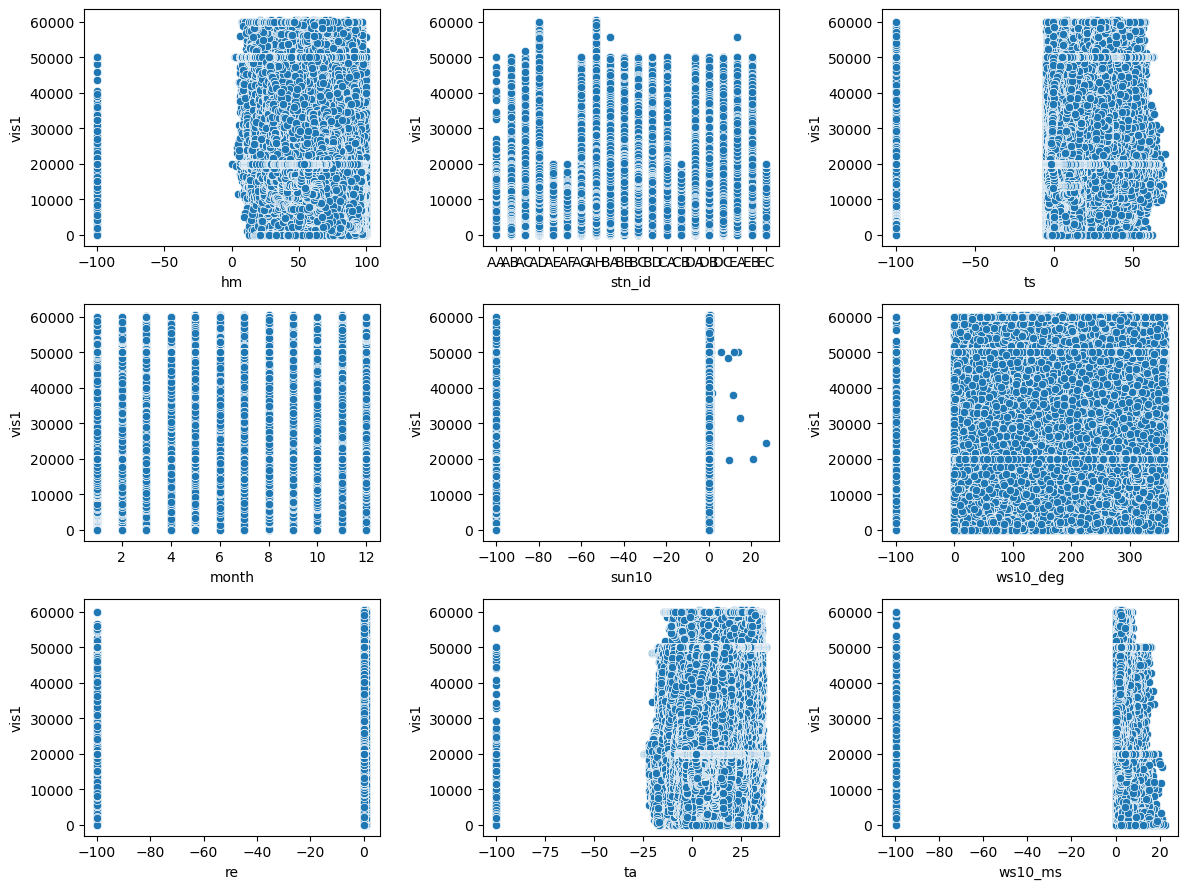

In [29]:
# train_df 시각화 (scatterplot)
# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(coef_columns_tr, axes): 
    sns.scatterplot(data=train_df, x=col, y='vis1', ax=ax)

fig.tight_layout()
plt.show()    

In [30]:
# train_df vis1 (1분 평균 시정) 확인
train_df['vis1'].max()

60525

In [31]:
# train_df 관측소별 vis 확인 - 최대값
train_df.groupby(["stn_id"])["vis1"].max()

stn_id
AA    50000
AB    50100
AC    51639
AD    60000
AE    20000
AF    20000
AG    50000
AH    60525
BA    55537
BB    50000
BC    50000
BD    50000
CA    50000
CB    20000
DA    50000
DB    50000
DC    50100
EA    55537
EB    50000
EC    20000
Name: vis1, dtype: int64

In [32]:
# train_df 관측소별 vis 확인 - 최소값 (결측치인 -99 나옴)
train_df.groupby(["stn_id"])["vis1"].min()

stn_id
AA   -99
AB   -99
AC   -99
AD   -99
AE   -99
AF   -99
AG   -99
AH   -99
BA   -99
BB   -99
BC   -99
BD   -99
CA   -99
CB   -99
DA   -99
DB   -99
DC   -99
EA   -99
EB   -99
EC   -99
Name: vis1, dtype: int64

In [33]:
# train_df 관측소별 vis 확인 (-99인 결측치 제외)
train_df[train_df.vis1 >=0].groupby(["stn_id"])["vis1"].min()

stn_id
AA      1
AB     20
AC     88
AD      4
AE     30
AF     87
AG     11
AH     10
BA     26
BB     62
BC     80
BD     17
CA     17
CB    178
DA      8
DB     10
DC     18
EA     10
EB     52
EC      4
Name: vis1, dtype: int64

In [34]:
# train_df["class"]의 결측치 비율 확인
train_df["class"].value_counts(normalize=True)

class
 4     0.982686
-99    0.007133
 3     0.003859
 2     0.003830
 1     0.002492
Name: proportion, dtype: float64

In [35]:
# train_df 수치형 변수만 확인
num_cols = train_df.describe().columns
train_df[num_cols]

,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,1,1,0,10,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,1,1,0,20,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,1,1,0,30,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,1,1,0,40,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,1,1,0,50,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,12,31,23,10,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,12,31,23,20,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,12,31,23,30,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,12,31,23,40,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [36]:
# train_df 문자형 변수 확인
train_df.select_dtypes(include="object").columns

Index(['year', 'stn_id'], dtype='object')

In [37]:
train_df[train_df.vis1<20000]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
10,I,1,1,1,40,AA,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,18510,4
14,I,1,1,2,20,AA,38.5,0.1,-5.5,0.0,43.6,0.0,-2.6,18971,4
19,I,1,1,3,10,AA,40.8,0.0,-5.6,0.0,46.3,0.0,-2.6,19165,4
34,I,1,1,5,40,AA,-99.9,-99.9,-5.0,0.0,56.5,0.0,-2.1,18219,4
35,I,1,1,5,50,AA,-99.9,-99.9,-4.9,0.0,57.3,0.0,-2.1,17846,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156308,K,12,30,22,40,EC,289.8,4.2,2.3,0.0,56.6,0.0,-0.9,17647,4
3156309,K,12,30,22,50,EC,271.7,2.7,2.2,0.0,56.9,0.0,-1.2,18750,4
3156310,K,12,30,23,0,EC,275.7,2.7,2.1,0.0,57.0,0.0,-1.5,-99,-99
3156311,K,12,30,23,10,EC,283.6,2.5,1.9,0.0,57.2,0.0,-1.5,18750,4


In [38]:
1427376 / train_df.shape[0]

0.4522079963655476

### `stn_id` 수정
- A, B, C, D, E로 수정

In [103]:
train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
train_df["stn_id"]

1          A
2          A
3          A
4          A
5          A
          ..
3156455    E
3156456    E
3156457    E
3156458    E
3156459    E
Name: stn_id, Length: 3156459, dtype: object

In [104]:
test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])
test_df["stn_id"]

1         A
2         A
3         A
4         A
5         A
         ..
262796    E
262797    E
262798    E
262799    E
262800    E
Name: stn_id, Length: 262800, dtype: object

### `class` 결측치 제거
- `-99`인 데이터 삭제

In [105]:
# class=-99인 데이터 index
class_99_idx_tr = train_df.loc[train_df["class"]==-99].index
class_99_idx_test = test_df.loc[test_df["class"]==-99].index

In [106]:
# index 기반으로 class=-99인 데이터 삭제
train_df.drop(index=class_99_idx_tr, inplace=True)
test_df.drop(index=class_99_idx_test, inplace=True)

## 모델링

### 데이터 분리

In [107]:
# Target 컬럼 : vis1
target = "vis1"

# train_df의 컬럼들 중 vis1, class 제외한 컬럼들 features에 선언
features = train_df.drop(columns=[target, "class"]).columns

In [108]:
# test 데이터에 target 컬럼 (vis1) 만들어 빈 데이터 넣어준다
test_df["vis1"] = ""

In [109]:
# validation 데이터셋 생성
train, val = train_test_split(train_df, train_size=0.8, random_state=42)

In [110]:
# train, validation, test 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다 (class 제거)
X_test = test_df[features]
y_test = test_df[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2507154, 13), (2507154,), (626789, 13), (626789,), (260106, 13), (260106,))

### 인코딩

#### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [77]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = train_df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

### 회귀모델 평가 지표  
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻


- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [78]:
def get_rmsle(y_actual, y_pred):
    # sklearn의 mean_square_log_error 함수는 y_pred 값 중 하나라도 0 미만인 경우 에러 발생
    # y_pred + 1 만들어 0보다 크게 만들어 준다 (음수가 되지 않게 방지)
    # 이후 optuna에 적용하여 RMSLE를 기준으로 하이퍼파라미터 튜닝
    
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

### Baseline 모델 생성

In [48]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("------------------------------ \n")
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  -4481.7824687001885
------------------------------ 

Coefficients:


[('year', 0.8868428142354845),
 ('month', 471.3057398082832),
 ('day', 12.391912489814127),
 ('time', 10.215299361435495),
 ('minute', -0.18229286566874814),
 ('stn_id', 0.823135650814379),
 ('ws10_deg', -4.31933647704173),
 ('ws10_ms', 120.43747170254248),
 ('ta', 131.18548252690778),
 ('re', 3.3292803533171424),
 ('hm', -208.29117001889378),
 ('sun10', -41.998115586820276),
 ('ts', -21.88576051187593)]

In [50]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr, squared=False)
    base_rootMeanSqLogErr = get_rmsle(y_val, y_val_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [51]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Linear Regression,7822.28,114185030.05,10685.74,0.71,0.21


### 머신러닝 모델링

#### 하이퍼 파라미터 튜닝 전 모델 생성

In [114]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

models = [
    ("Linear Regression", LinearRegression()),
    # ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    # ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [53]:
def model_comparison(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
        meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)
        rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [54]:
model_comparison(models)

Learning rate set to 0.14101
0:	learn: 11648.5288455	total: 335ms	remaining: 5m 34s
1:	learn: 11383.3606742	total: 536ms	remaining: 4m 27s
2:	learn: 11171.0673710	total: 722ms	remaining: 4m
3:	learn: 10998.3981643	total: 911ms	remaining: 3m 46s
4:	learn: 10861.0390000	total: 1.08s	remaining: 3m 35s
5:	learn: 10745.6753989	total: 1.27s	remaining: 3m 31s
6:	learn: 10657.3759349	total: 1.45s	remaining: 3m 25s
7:	learn: 10580.5605163	total: 1.62s	remaining: 3m 21s
8:	learn: 10517.1810694	total: 1.83s	remaining: 3m 21s
9:	learn: 10463.4266558	total: 2.01s	remaining: 3m 18s
10:	learn: 10418.8843966	total: 2.23s	remaining: 3m 20s
11:	learn: 10379.5191802	total: 2.4s	remaining: 3m 18s
12:	learn: 10347.2315264	total: 2.6s	remaining: 3m 17s
13:	learn: 10318.7935994	total: 2.8s	remaining: 3m 17s
14:	learn: 10293.6807528	total: 2.98s	remaining: 3m 16s
15:	learn: 10267.3321546	total: 3.14s	remaining: 3m 13s
16:	learn: 10244.1410224	total: 3.33s	remaining: 3m 12s
17:	learn: 10224.4547342	total: 3.51

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost,6246.55,76822291.46,8764.83,0.59,0.47
1,XGBoost,6367.94,79681900.26,8926.47,0.60,0.45
2,LightGBM,6735.76,88721580.03,9419.21,0.63,0.38
3,Linear Regression,7822.28,114185030.05,10685.74,0.71,0.21


##### 모델링 결과 (하이퍼 파라미터 튜닝 전)
- `CatBoost`가 성능 가장 좋게 나왓다

    - `RMSLE` : 0.59
    - `R2 Score` : 0.47

In [55]:
test_copy_cat = test_df.copy()
cat_model.fit(X_train, y_train)

Learning rate set to 0.14101
0:	learn: 11648.5288455	total: 197ms	remaining: 3m 17s
1:	learn: 11383.3606742	total: 385ms	remaining: 3m 11s
2:	learn: 11171.0673710	total: 577ms	remaining: 3m 11s
3:	learn: 10998.3981643	total: 784ms	remaining: 3m 15s
4:	learn: 10861.0390000	total: 960ms	remaining: 3m 11s
5:	learn: 10745.6753989	total: 1.15s	remaining: 3m 10s
6:	learn: 10657.3759349	total: 1.32s	remaining: 3m 7s
7:	learn: 10580.5605163	total: 1.5s	remaining: 3m 6s
8:	learn: 10517.1810694	total: 1.71s	remaining: 3m 8s
9:	learn: 10463.4266558	total: 1.93s	remaining: 3m 10s
10:	learn: 10418.8843966	total: 2.14s	remaining: 3m 12s
11:	learn: 10379.5191802	total: 2.32s	remaining: 3m 11s
12:	learn: 10347.2315264	total: 2.55s	remaining: 3m 13s
13:	learn: 10318.7935994	total: 2.83s	remaining: 3m 19s
14:	learn: 10293.6807528	total: 3.06s	remaining: 3m 21s
15:	learn: 10267.3321546	total: 3.25s	remaining: 3m 19s
16:	learn: 10244.1410224	total: 3.45s	remaining: 3m 19s
17:	learn: 10224.4547342	total: 3

In [79]:
test_copy_cat["vis1"] = cat_model.predict(X_test)

In [80]:
test_copy_cat["vis1"]

1         13909.507298
2         13353.019837
3         13925.712742
4         12735.168237
5         11038.823208
              ...     
262796     2159.978047
262797     4857.415763
262798     3872.636379
262799    14481.775316
262800    22691.716274
Name: vis1, Length: 260106, dtype: float64

In [81]:
test_copy_cat[test_copy_cat["vis1"]<=1000]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,vis1
863,L,1,6,23,40,AI,259.0,0.4,-0.6,1.0,94.1,0.0,-0.9,NaN,569.384038
864,L,1,6,23,50,AI,248.3,0.5,-0.6,1.0,95.6,0.0,-0.9,NaN,-46.064534
865,L,1,7,0,0,AI,335.0,0.8,-0.6,1.0,96.4,0.0,-0.9,NaN,-313.681933
866,L,1,7,0,10,AI,182.8,0.4,-0.6,1.0,96.9,0.0,-0.9,NaN,-136.823065
867,L,1,7,0,20,AI,229.9,0.2,-0.7,1.0,97.5,0.0,-0.9,NaN,-3162.919472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260345,L,12,14,22,40,ED,78.7,6.4,10.9,0.0,95.0,0.0,10.6,NaN,-1198.693888
260346,L,12,14,22,50,ED,75.6,6.8,10.8,0.0,95.5,0.0,10.6,NaN,-3082.050808
260347,L,12,14,23,0,ED,78.1,7.3,10.7,0.0,96.0,0.0,10.6,NaN,-3497.533333
260348,L,12,14,23,10,ED,78.0,6.3,10.8,0.0,96.1,0.0,10.6,NaN,-2518.743845


In [83]:
test_copy_cat[test_copy_cat["vis1"]<=0]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,vis1
864,L,1,6,23,50,AI,248.3,0.5,-0.6,1.0,95.6,0.0,-0.9,NaN,-46.064534
865,L,1,7,0,0,AI,335.0,0.8,-0.6,1.0,96.4,0.0,-0.9,NaN,-313.681933
866,L,1,7,0,10,AI,182.8,0.4,-0.6,1.0,96.9,0.0,-0.9,NaN,-136.823065
867,L,1,7,0,20,AI,229.9,0.2,-0.7,1.0,97.5,0.0,-0.9,NaN,-3162.919472
868,L,1,7,0,30,AI,133.3,0.4,-0.7,1.0,98.0,0.0,-0.9,NaN,-1561.738752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260345,L,12,14,22,40,ED,78.7,6.4,10.9,0.0,95.0,0.0,10.6,NaN,-1198.693888
260346,L,12,14,22,50,ED,75.6,6.8,10.8,0.0,95.5,0.0,10.6,NaN,-3082.050808
260347,L,12,14,23,0,ED,78.1,7.3,10.7,0.0,96.0,0.0,10.6,NaN,-3497.533333
260348,L,12,14,23,10,ED,78.0,6.3,10.8,0.0,96.1,0.0,10.6,NaN,-2518.743845


In [93]:
test_copy_cat[(test_copy_cat["vis1"]>=0) & (test_copy_cat["vis1"]<200)].shape[0] / test_copy_cat.shape[0] *100

0.018454014901617032

In [94]:
test_copy_cat[(test_copy_cat["vis1"]>=200) & (test_copy_cat["vis1"]<500)].shape[0] / test_copy_cat.shape[0]*100

0.03306344336539718

In [95]:
test_copy_cat[(test_copy_cat["vis1"]>=500) & (test_copy_cat["vis1"]<1000)].shape[0] / test_copy_cat.shape[0]*100

0.0488262477605284

In [96]:
test_copy_cat[test_copy_cat["vis1"]<=0].shape[0] / test_copy_cat.shape[0]*100

0.21106779543724483

In [99]:
train_df[(train_df["vis1"]>=0) & (train_df["vis1"]<1000)].shape[0] / train_df.shape[0] *100

1.0253536838417292

#### no target encoding

In [119]:
# target encoding 거치지 않은 데이터셋으로 catboost

In [117]:
test_copy_cat2 = test_df.copy()

In [ ]:
from catboost import Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=)

In [118]:
cat_model.fit(X_train, y_train)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="I": Cannot convert 'b'I'' to float

In [111]:
X_train

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
960604,I,3,23,23,40,E,4.9,0.1,9.4,0.0,40.9,0.00,6.4
2692611,K,3,5,19,50,B,289.0,6.5,-2.8,0.0,19.7,0.00,-3.5
2188275,K,7,31,11,50,A,344.2,2.1,28.0,0.0,88.1,0.08,30.9
803205,I,3,28,22,0,D,359.7,5.6,5.5,0.0,65.8,0.00,4.7
320021,I,1,27,9,50,A,27.7,2.7,6.4,0.0,45.4,0.04,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706219,J,5,29,21,0,C,230.0,3.5,17.1,0.0,58.1,0.00,15.0
2373439,K,2,7,8,30,A,68.2,3.4,-2.3,0.0,55.4,0.04,-1.8
2245801,K,9,3,23,30,A,136.5,3.5,21.6,0.0,98.9,0.00,22.9
2787611,K,12,25,13,10,C,38.7,3.1,6.1,0.0,43.2,0.29,6.1


In [82]:
X_test.stn_id.value_counts()

stn_id
18519.376848    52336
20171.424627    52081
22421.470061    52077
23135.085420    51923
18211.698092    51689
Name: count, dtype: int64

In [58]:
test_copy_cat["vis1"].value_counts()

vis1
15814.993331    3
21928.245923    3
19379.343451    3
6252.571089     3
14784.684102    3
               ..
20733.394818    1
23953.202396    1
14763.698698    1
14755.970713    1
17306.528229    1
Name: count, Length: 259599, dtype: int64

In [123]:
np.random.seed(240530)
# 챕터 6, 7, 8-1, 8-2
# np.random.randint(4, size=4, )/
# np.random.choice(4, size=4, replace=False, p=None)

weather = ["기훈", "상택", "우진", "정규"]
p = [0.25, 0.25, 0.25, 0.25]
np.random.choice(weather, 4, p=p, replace=False)

array(['상택', '우진', '정규', '기훈'], dtype='<U2')

In [ ]:
np.random.seed(240518)

# np.random.randint(4, size=4, )/
# np.random.choice(4, size=4, replace=False, p=None)

weather = ["기훈", "상택", "우진", "정규"]
p = [0.25, 0.25, 0.25, 0.25]
np.random.choice(weather, 6, p=p, replace=False)